<div style="display: flex;">
  <div style="width:70%; padding-right: 40px;">
    <h1>Breast cancer</h1>
    <p>
        Breast cancer is one of the leading causes of mortality in women worldwide. The Wisconsin Breast Cancer (WBC) dataset is widely used in medical research for the detection and diagnosis of this disease. This dataset contains features obtained from digital images of fine-needle aspiration biopsies of breast masses, which allows for the classification of tumors as benign or malignant. The features include measurements such as size, texture, symmetry, and other attributes related to cell shape and structure, providing key information for developing predictive models and improving early detection of breast cancer.
    </p>
  </div>

  <div style="width: 30%; display: flex; flex-direction: row; justify-content: center;">
    <div style="background-color: #f0f0f0;"><img src="./img.png" style="width:400px; height:300px;"></div>
  </div>

</div>

### Librerías necesarias

In [3]:
#!pip install scikeras[tensorflow-cpu]
#! pip install ucimlrepo
#!pip install plottable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import ipywidgets as widgets
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from plottable import Table

### IMPORTAR DATOS

In [4]:
from ucimlrepo import fetch_ucirepo

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets
df = pd.concat([X, y], axis=1)

display(df.head())

radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  texture3  \
0      0.3001          0.14710     0.2419             0.07871  ...     17.33   
1      0.0869          0.07017     0.1812             0.05667  ...     23.41   
2      0.1974          0.12790     0.2069             0.05999  ...     25.53   
3      0.2414          0.10520     0.2597             0.09744  ...     26.50   
4      0.1980          0.10430     0.1809             0.05883  ...     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0      184.60  2019.0       0.1622        0.6656      0.7119           0.2654   
1      158.80  1956.0       0.1238        0.1866      0.2416           0.1860   
2      152.50  1709.0       0.1444        0.4245      0.4504           0.2430   
3       98.87   567.7       0.2098        0.8663      0.6869           0.2575   
4      152.20  1575.0       0.1374        0.2050      0.4000           0.1625   

   symmetry3  fractal_dimension3  Diagnosis  
0     0.4601             0.11890          M  
1     0.2750             0.08902          M  
2     0.3613             0.08758          M  
3     0.6638             0.17300          M  
4     0.2364             0.07678          M  

[5 rows x 31 columns]

**ANALYSIS OF BREAST CANCER DATA**

The convention of numbers in column names (1, 2, and 3) is generally based on the structure of the breast cancer diagnosis dataset. Here's how these numbers are used to categorize different metrics of tumors:

- **Number 1: Average**  
  Columns ending in "1" represent the average value of a particular feature calculated from the tumor cells. For example, *radius1* (or "Average Radius") indicates the average of the radii of the cells.

- **Number 2: Error**  
  Columns ending in "2" usually represent the standard error or deviation of the feature from the mean. For example, *radius2* (or "Radius Error") indicates the variation in the radii of the cells, providing a measure of data spread.

- **Number 3: Largest Value**  
  Columns ending in "3" indicate the largest recorded value for that specific feature among the tumor cells. For example, *radius3* (or "Largest Radius") refers to the largest observed radius among the cells.

**Visual Example**:
- *Radius*:  
  - *radius1*: Average cell radius.  
  - *radius2*: Error of the average radius (radius variation).  
  - *radius3*: Largest observed radius.

This structure facilitates analysis, as it allows the researcher to observe the average behavior, variability, and extreme values of each tumor characteristic in the dataset.

This is based on the original documentation and description of the dataset known as the "Breast Cancer Wisconsin (Diagnostic) Data Set." This dataset is widely used in machine learning research and medical data analysis.

**Additional Information on Variables**:

1) Identification number  
2) Diagnosis (M = malignant, B = benign)  
3-32) Ten real-valued features are calculated for each cell nucleus:  

   a) Radius (mean of distances from the center to points on the perimeter)  
   b) Texture (standard deviation of grayscale values)  
   c) Perimeter  
   d) Area  
   e) Smoothness (local variation in radius lengths)  
   f) Compactness \((\frac{{\text{perimeter}^2}}{\text{area}} - 1.0)\)  
   g) Concavity (severity of concave portions of the contour)  
   h) Concave points (number of concave portions of the contour)  
   i) Symmetry  
   j) Fractal dimension ("coastline approximation" - 1)

**1. Replace M's with 1 and B's with 0.**

In [5]:
# Transform the data in the Diagnosis variable (categorical) into numbers
df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})

### Exploratory analysis

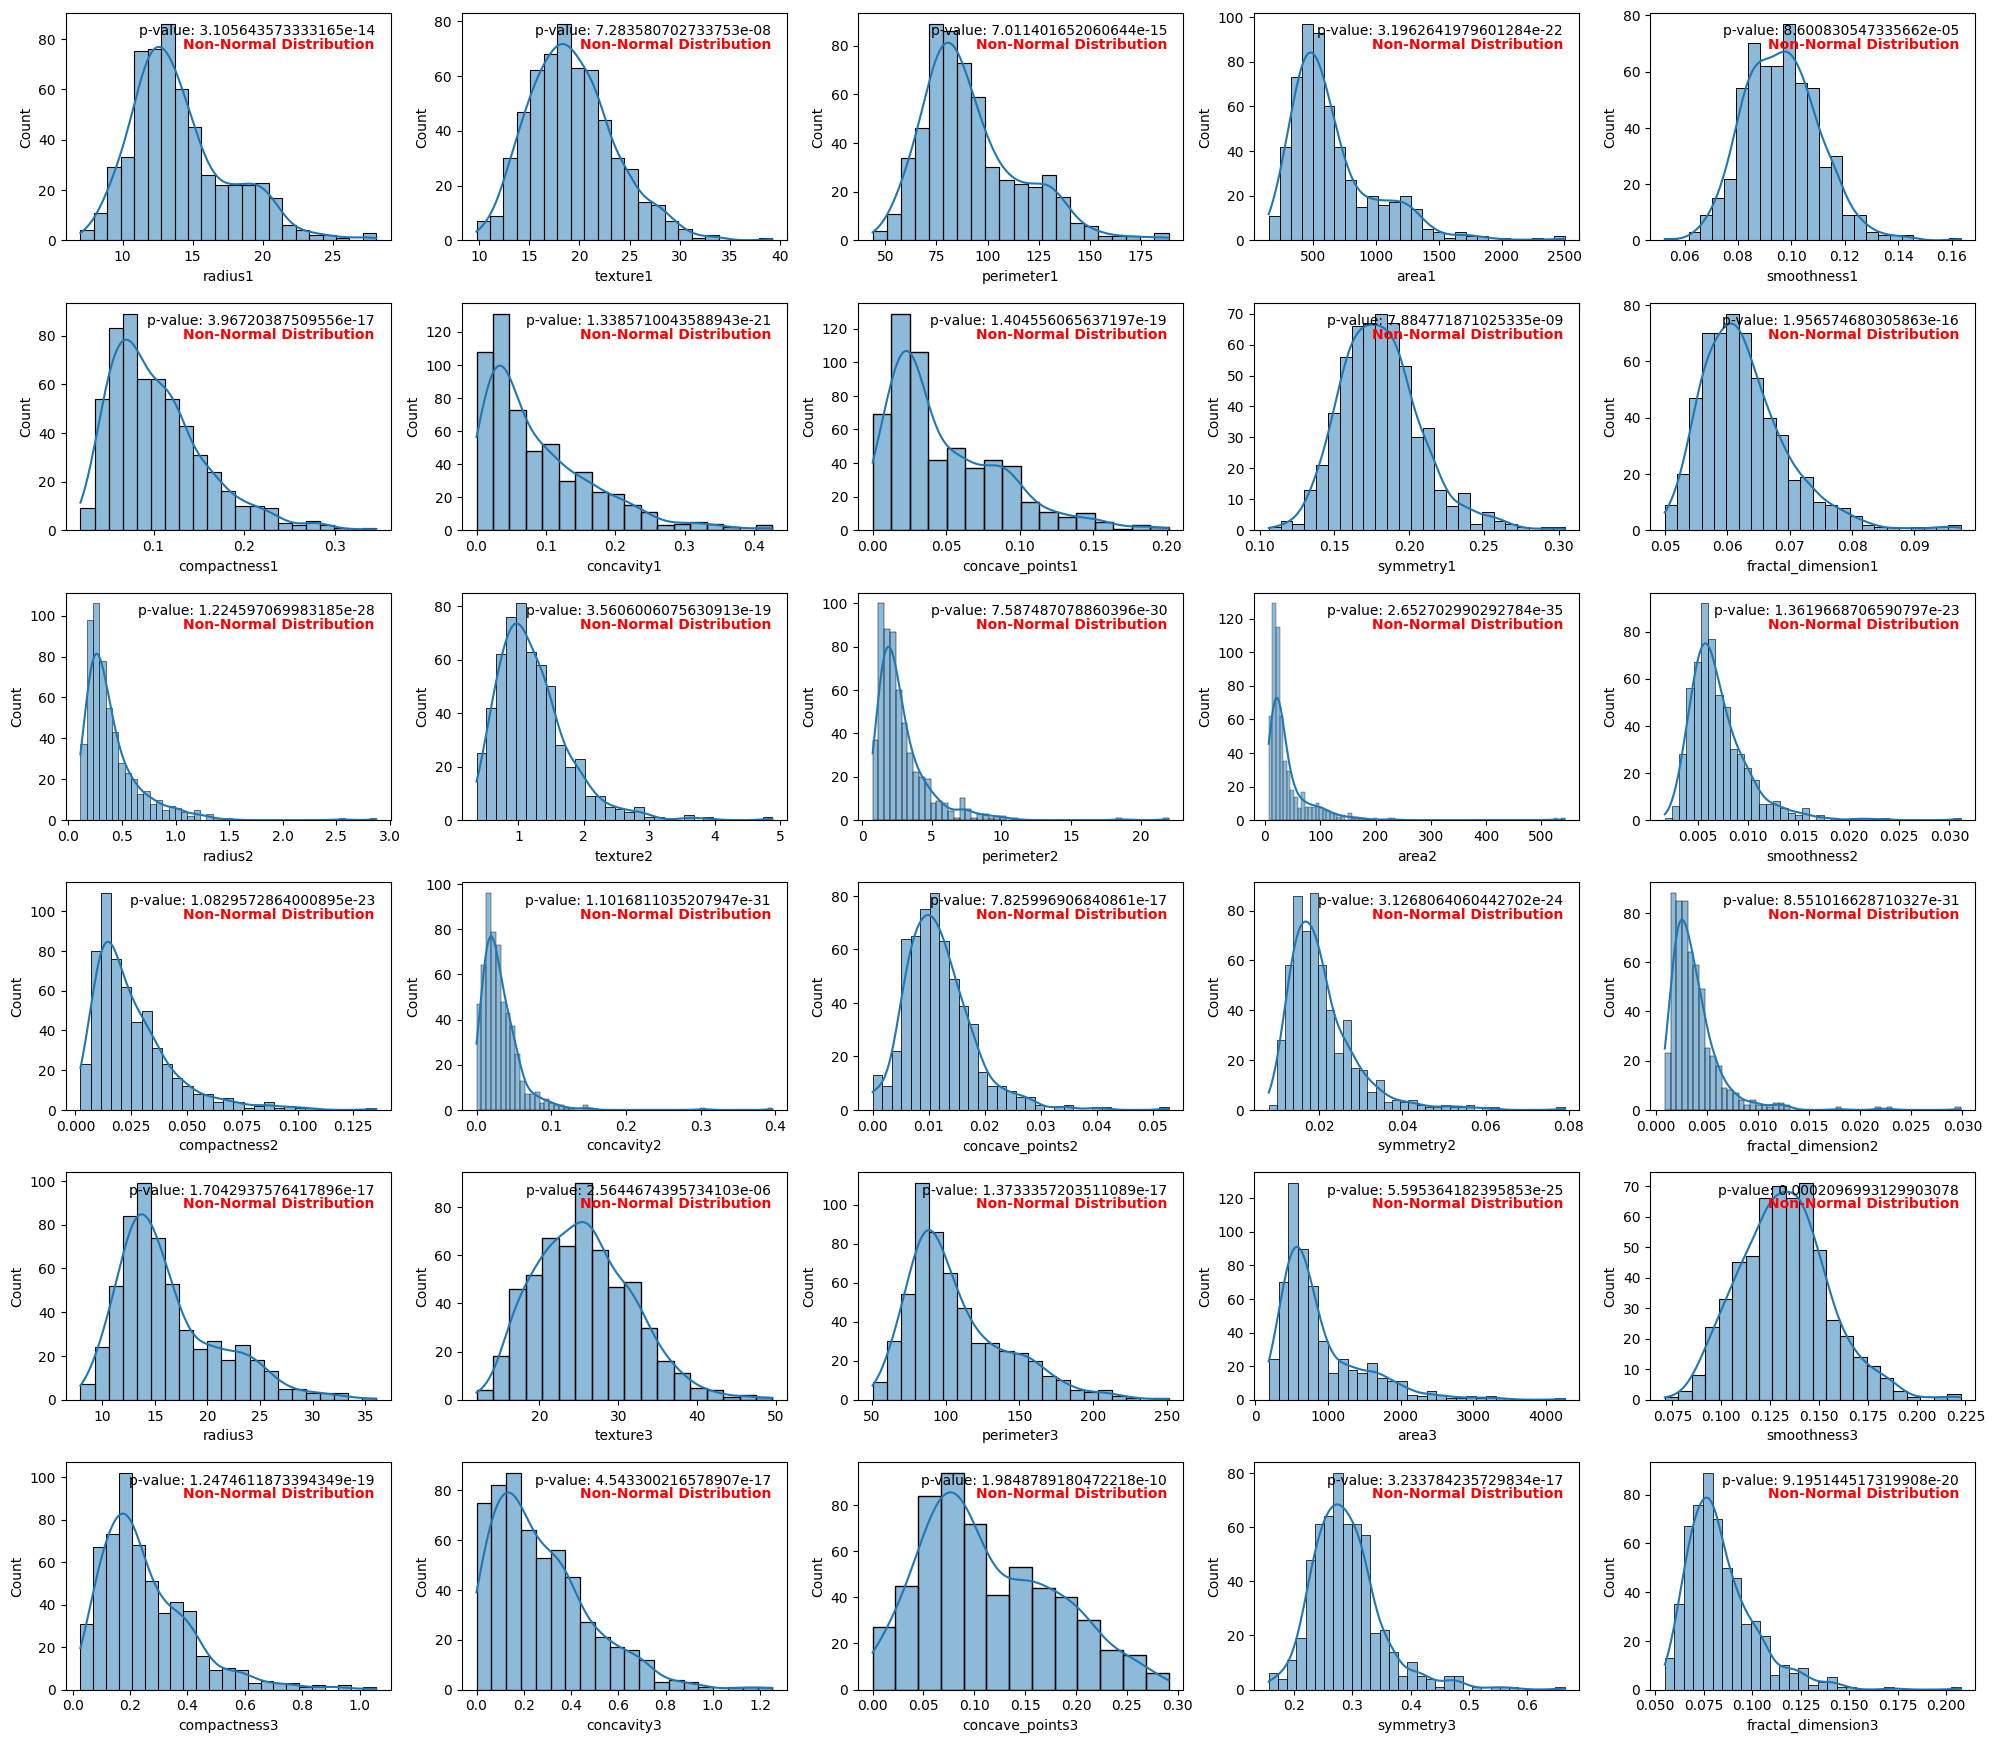

In [13]:
#It is identified whether the data follows a normal distribution or not.
plt.figure(figsize=(20, 20))
for index, col in enumerate(df.columns[:-1]):
    plt.subplot(math.ceil(len(df.columns) / 5), 5, index + 1)
    sns.histplot(df[col], kde=True)
    test, p = shapiro(df[col])
    plt.xlabel(col)
    plt.annotate(f"p-value: {p}", (0.95, 0.95), ha='right', va='top', xycoords='axes fraction')
    plt.annotate(
        f"{'Normal Distribution' if p > 0.05 else 'Non-Normal Distribution'}",
        xy=(0.95, 0.89), ha='right', va='top', xycoords='axes fraction',
        color=f"{'green' if p > 0.05 else 'red'}",
        fontweight='bold',
    )
plt.tight_layout()
plt.show()

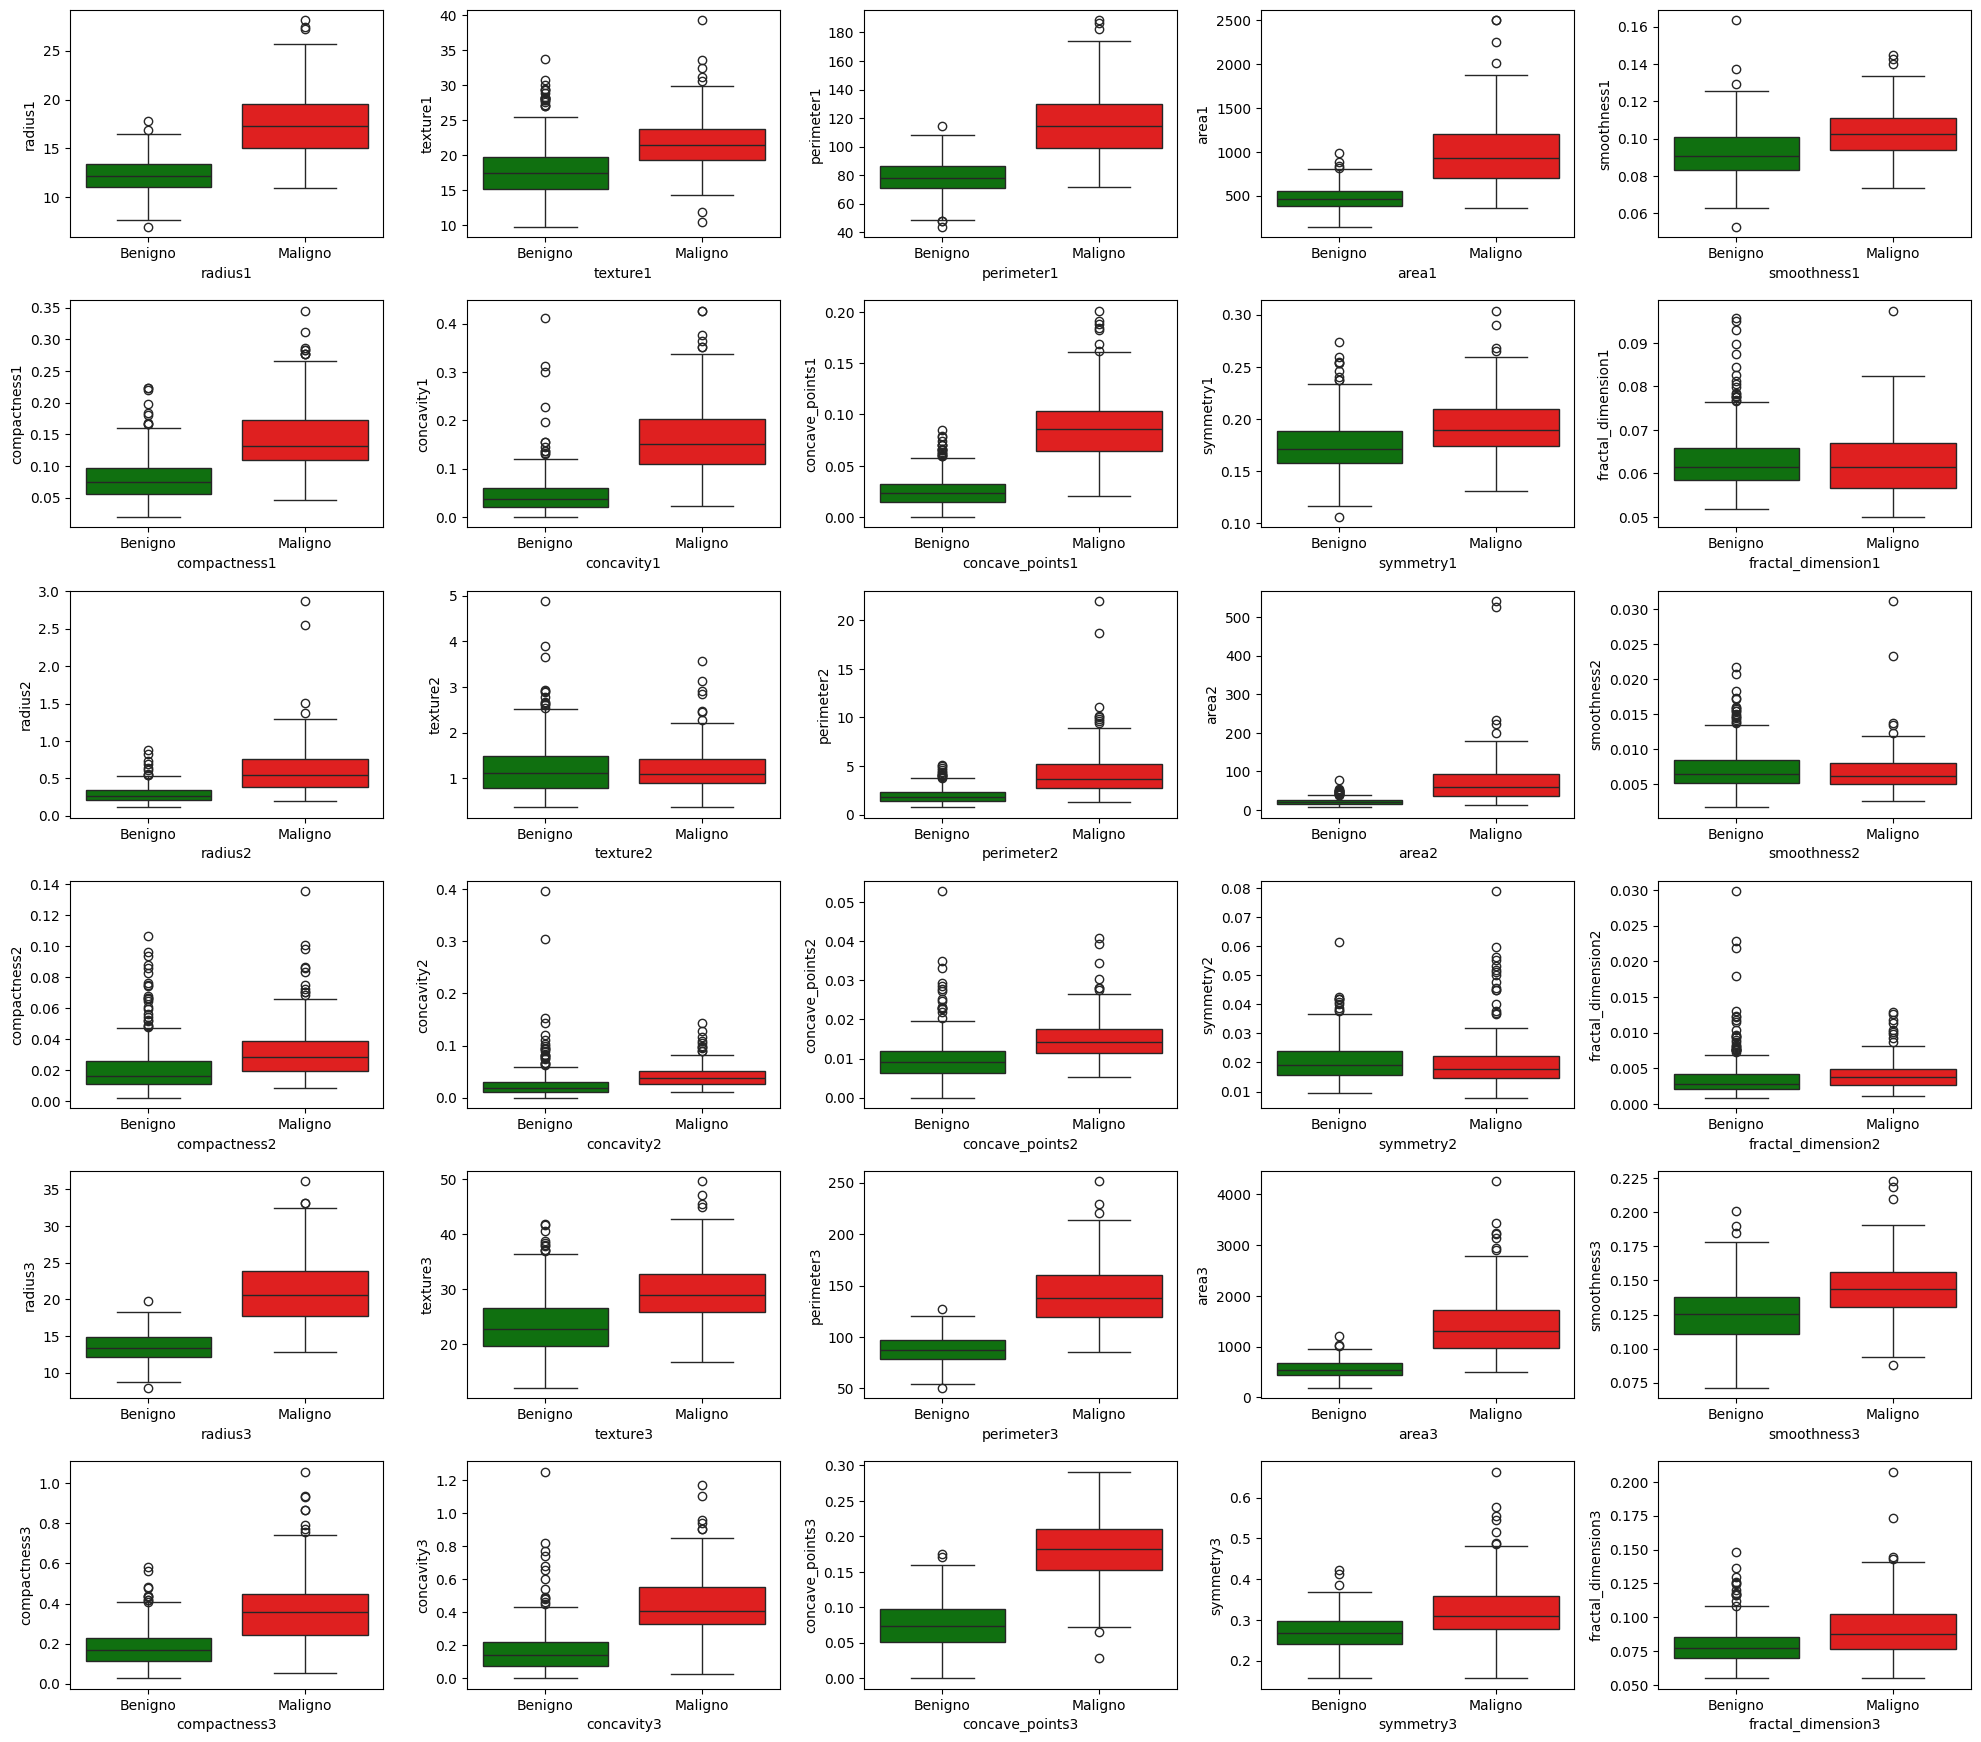

In [15]:
# Box plots are created to identify outliers.
plt.figure(figsize=(20, 20))
for index, col in enumerate(df.columns[:-1]):
    plt.subplot(math.ceil(len(df.columns) / 5), 5, index + 1)
    sns.boxplot(x=df["Diagnosis"], y=df[col], hue=df["Diagnosis"], palette={0: "green", 1: "red"}, legend=False)
    plt.xlabel(col)
    plt.xticks(ticks=[0, 1], labels=["Benigno", "Maligno"])
plt.tight_layout()
plt.show()

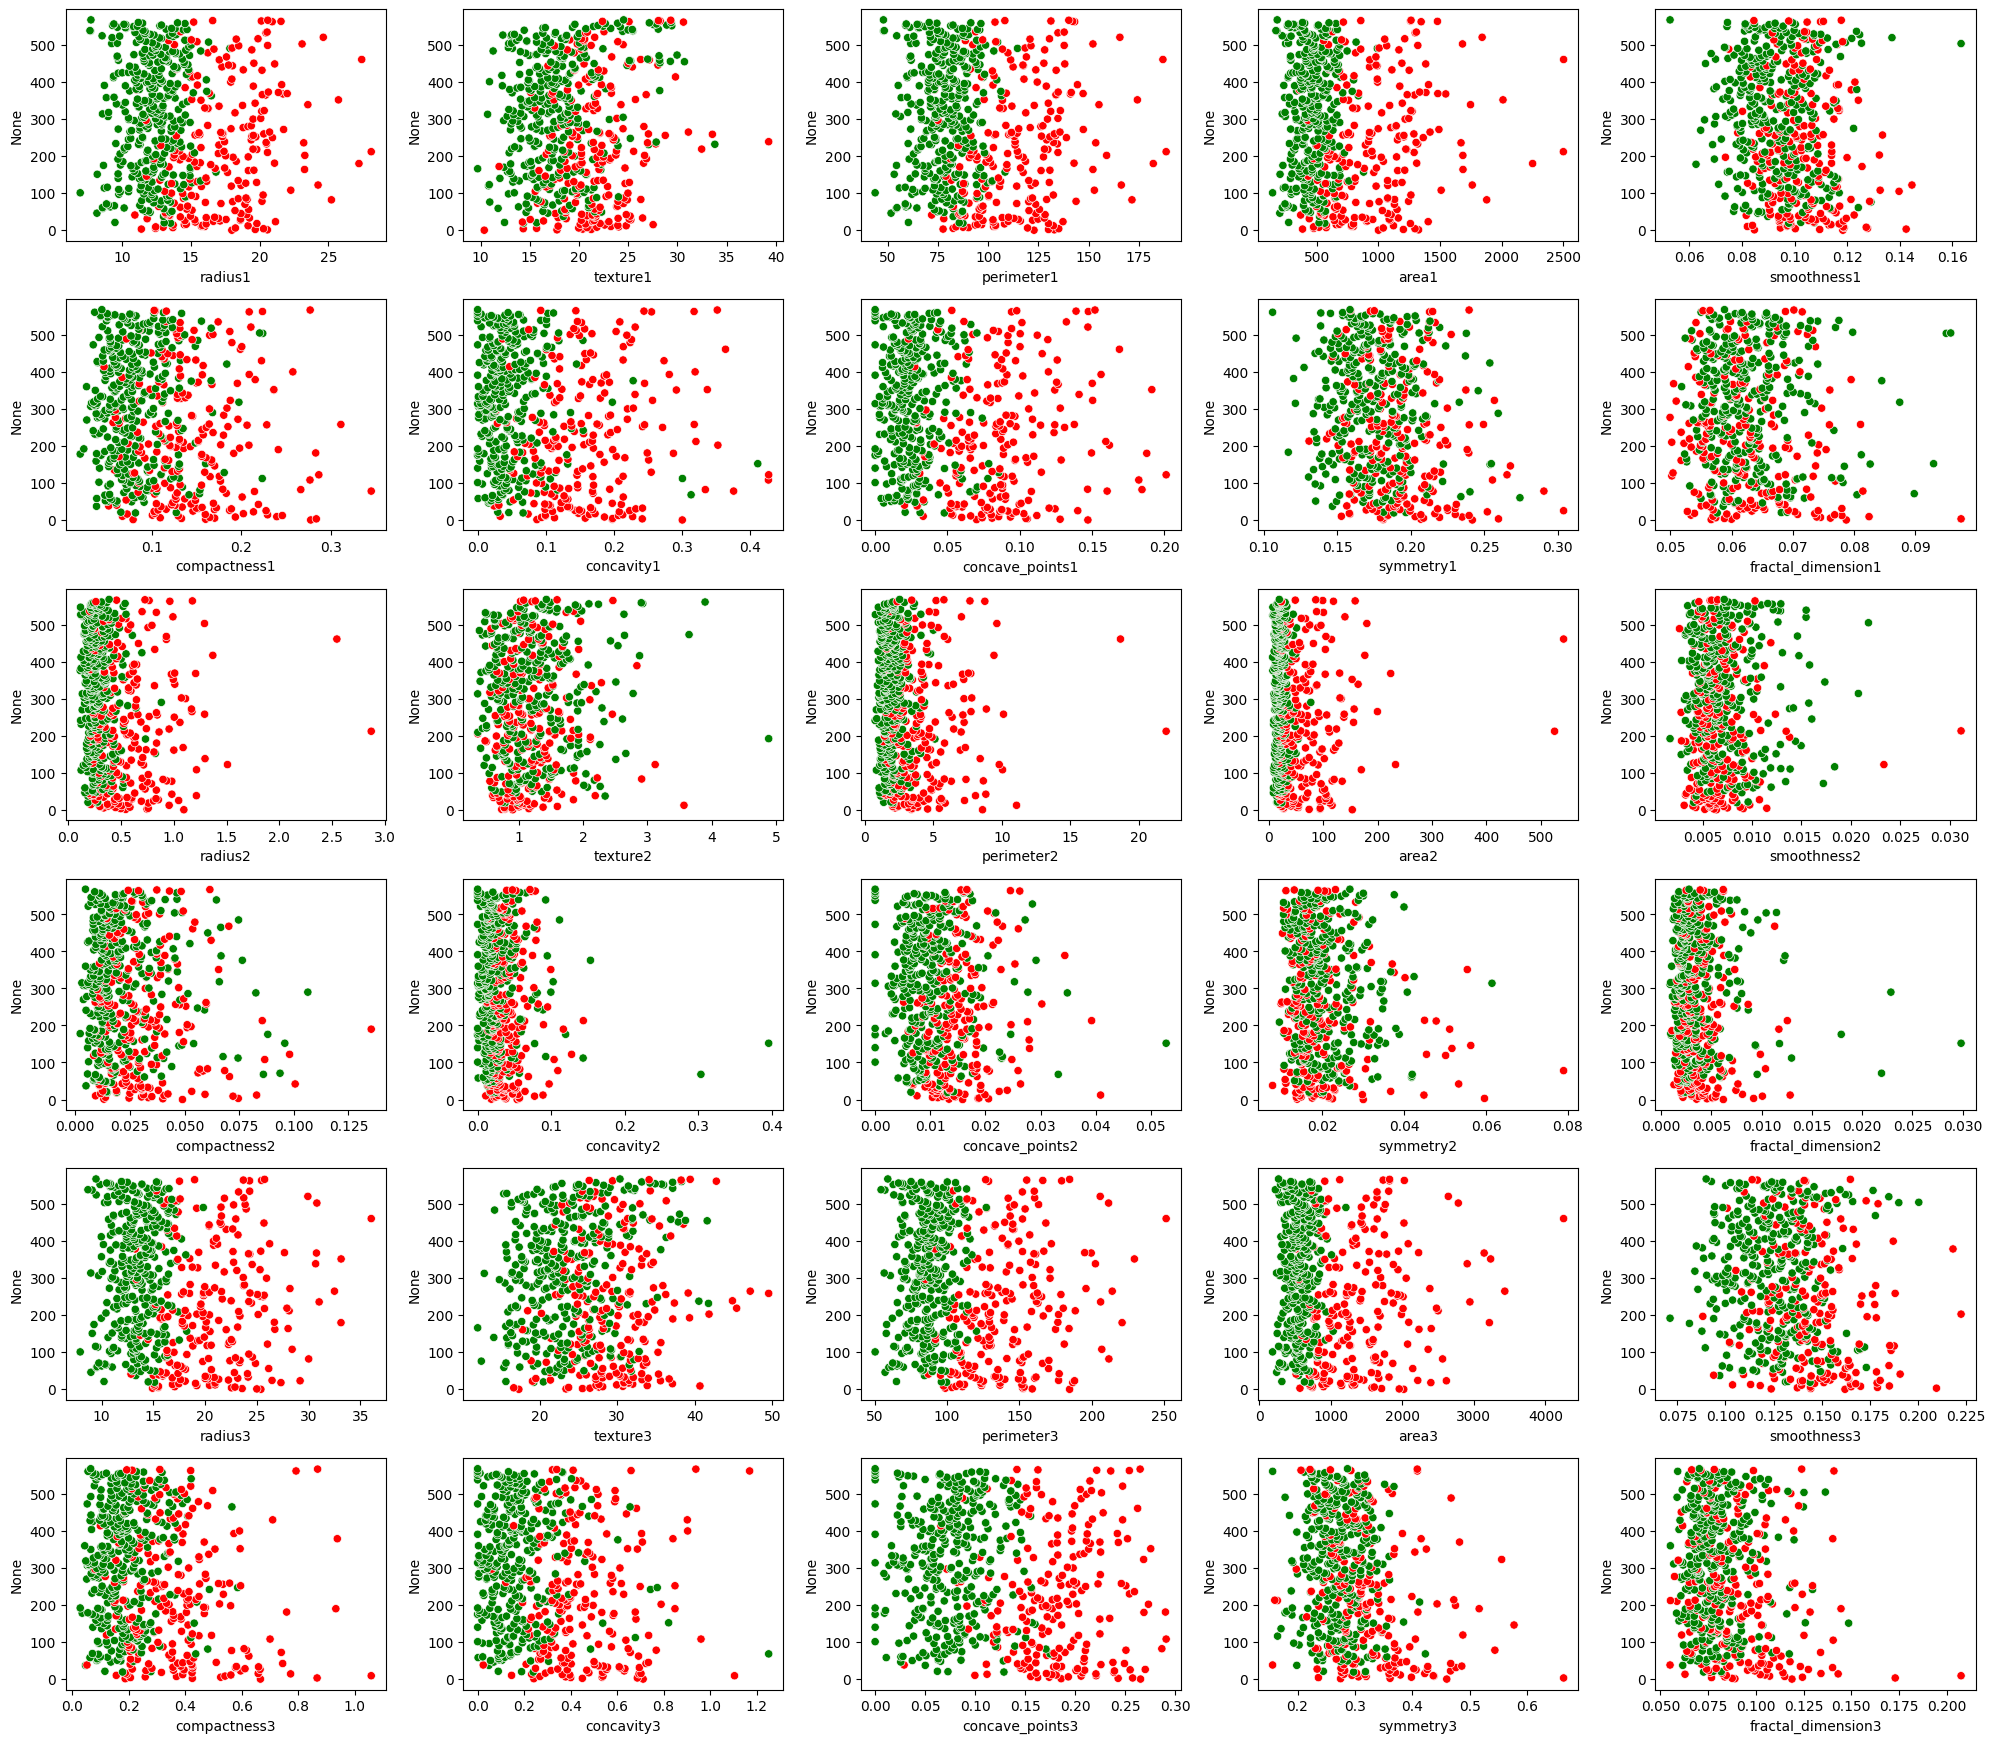

In [14]:
# A scatter plot is created, identifying benign and malignant cells by color.
plt.figure(figsize=(20, 20))
for index, col in enumerate(df.columns[:-1]):
    plt.subplot(math.ceil(len(df.columns) / 5), 5, index + 1)
    sns.scatterplot(x=df[col], y=df.index, hue=df["Diagnosis"], palette={0: "green", 1: "red"}, legend=False)
    plt.xlabel(col)
plt.tight_layout()
plt.show()

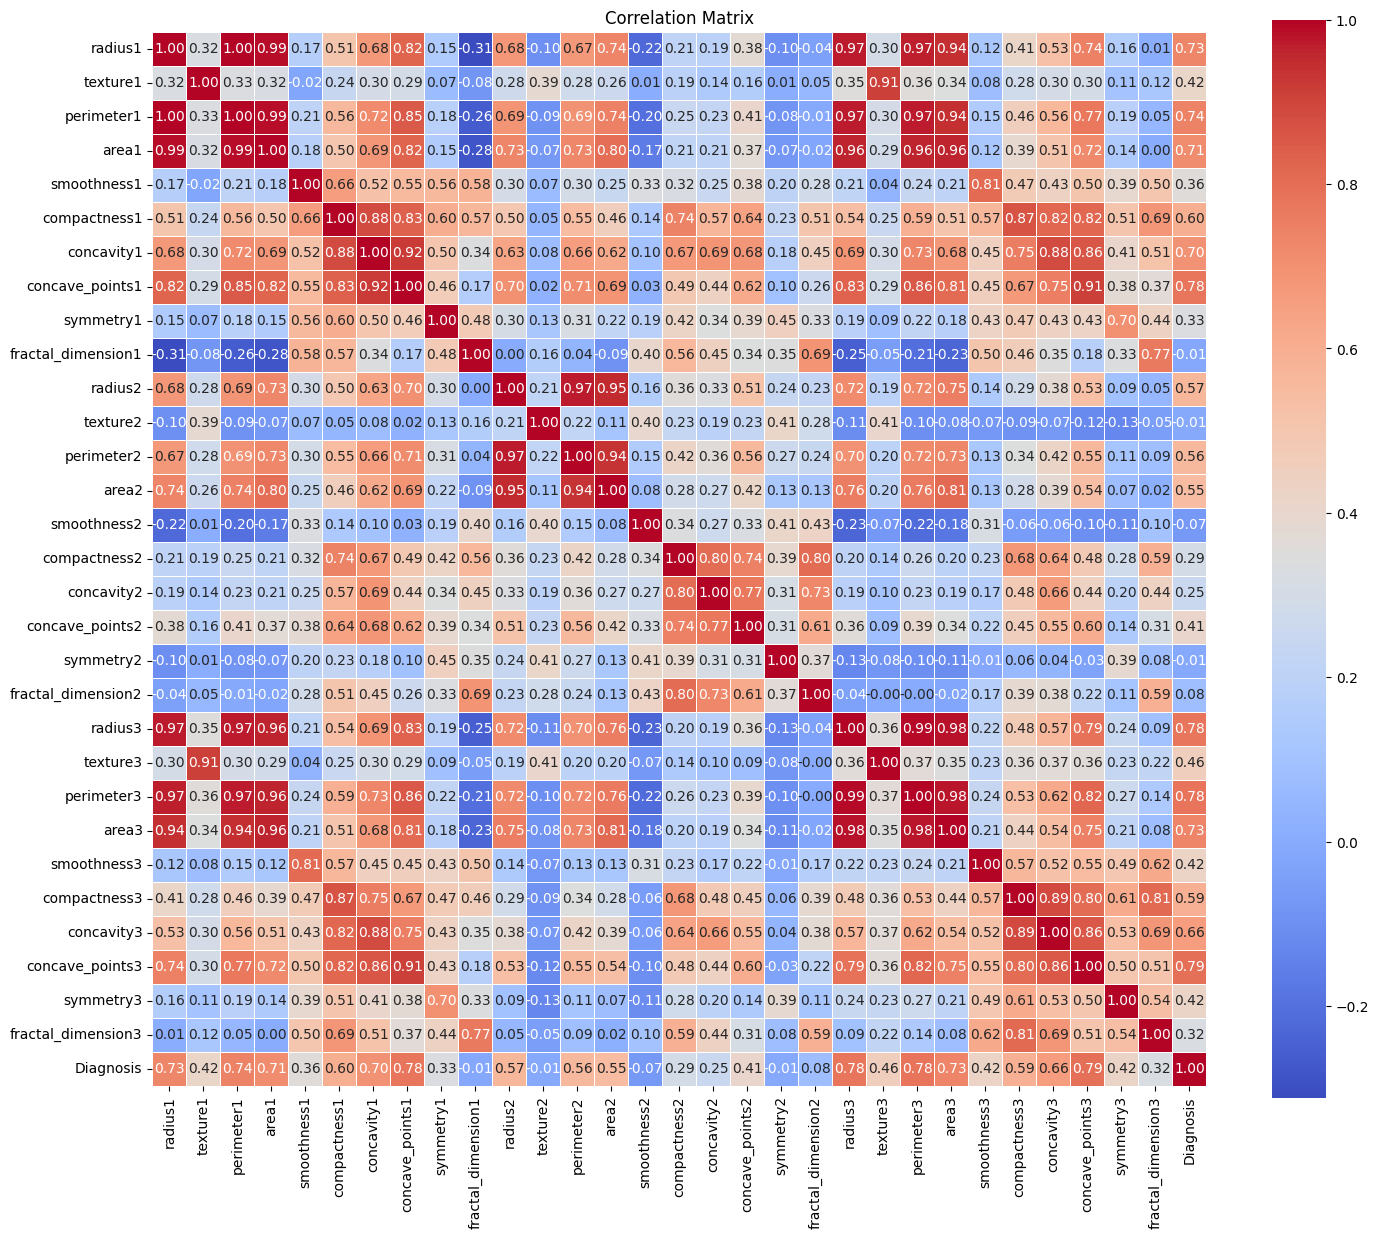

In [16]:
# Correlation Matrix
plt.figure(figsize=(17, 14))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            linewidths=0.7)
plt.title('Correlation Matrix')
plt.show()

# Creation of a DataFrame with model evaluation.

In [18]:
evaluation_results = pd.DataFrame(index=["Accuracy","Recall","Precision","Specificity","F1-Score","AUC","R2"])

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, r2_score
def CalculateAndAppendMetrics(db, y_test, y_pred, model_name):
  acc = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  specificity = recall_score(y_test, y_pred, pos_label=0)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  db[model_name] = [acc,recall,precision,specificity,f1,auc,r2]
  return db



# Logistic Regression

In [24]:
# The dataset is split into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, -1:], test_size=0.2, random_state=1)

### Validación Cruzada

Se lleva a cabo una validación cruzada para identificar cuál solver proporciona los mejores resultados en términos de precisión al aplicar un modelo de regresión logística.

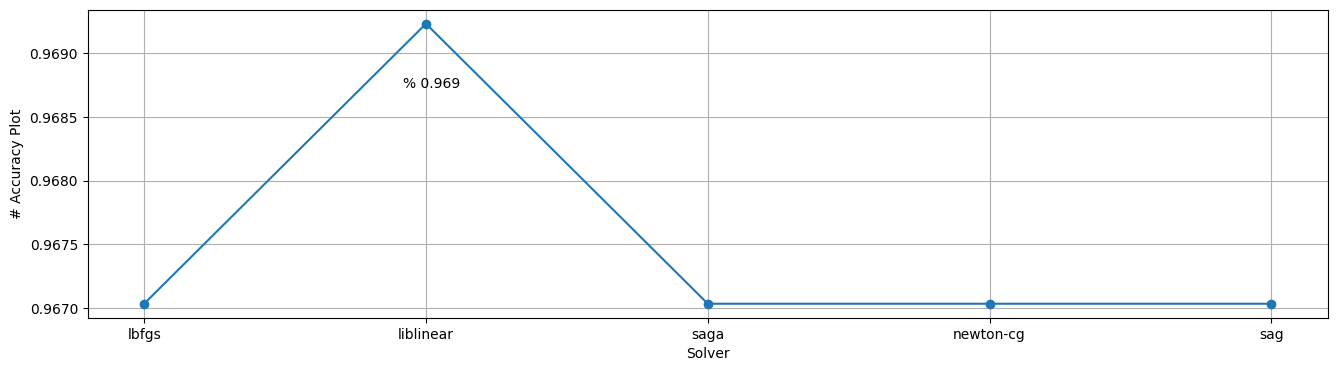

In [25]:
# The data is normalized for both the training and test sets.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

# Cross-validation

mean_scores = []
solver_values = ["lbfgs", "liblinear", "saga", "newton-cg", "sag"]
for solver in solver_values:
    logreg = LogisticRegression(random_state=10, solver=solver, max_iter=1000)
    scores = cross_val_score(logreg, X_train, y_train, cv=5)
    mean_scores.append(scores.mean())

best_solver = solver_values[np.argmax(mean_scores)]

# Accuracy Plot

plt.figure(figsize=(16, 4))
plt.plot(solver_values, mean_scores, marker='o')
plt.xlabel('Solver')
plt.ylabel('# Accuracy Plot')
plt.annotate(f"% {round(np.max(mean_scores), 3)}", xy=(np.argmax(mean_scores), np.max(mean_scores)),
             xytext=(np.argmax(mean_scores) - 0.08, np.max(mean_scores) - 0.0005))
plt.grid()
plt.show()

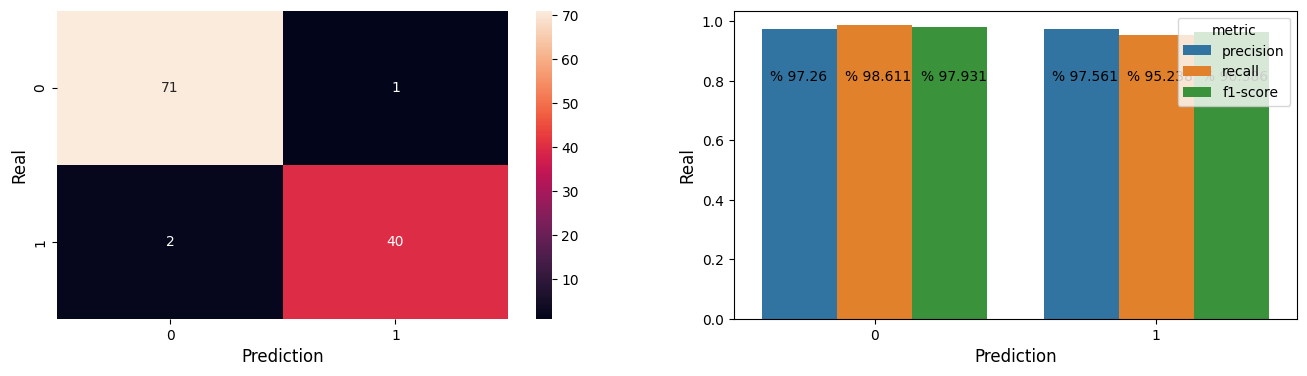

In [26]:
model = LogisticRegression(random_state=10, solver=solver, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, output_dict=True)

evaluation_results = CalculateAndAppendMetrics(evaluation_results, y_test, y_pred, "Logistic Regression")

diagnosis = []
metrics = []
values = []
for index, item in cr.items():

    if index not in ["0", "1"]:
        break
    for metric, value in item.items():
        if metric == "support":
            continue
        diagnosis.append(index)
        metrics.append(metric)
        values.append(value)

cr_data = pd.DataFrame({
    'diagnosis': diagnosis,
    'metric': metrics,
    'value': values
})

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

plt.subplot(1, 2, 2)
bar_plot = sns.barplot(data=cr_data, x='diagnosis', y='value', hue='metric')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

for i in bar_plot.patches[:6]:
    bar_plot.annotate(f"% {round(i.get_height() * 100, 3)}", xy=(i.xy[0] + 0.03, 0.8))

# K-Nearest Neighbors

In [29]:
# The dataset is split into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, -1:], test_size=0.8, random_state=1)

### Cross-validation

Cross-validation is performed to determine the optimal value of **K** that provides the best results in terms of accuracy when applying a **K-Nearest Neighbors (KNN)** model.

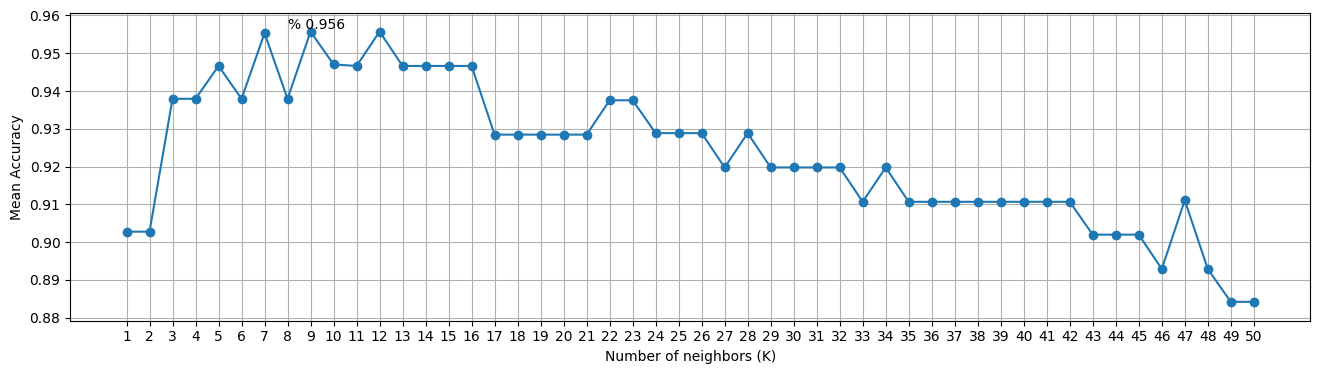

In [30]:
# The data is normalized for both the training and test sets.

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

# Cross-validation

k_values = range(1, 51)
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    mean_scores.append(scores.mean())

best_k = k_values[np.argmax(mean_scores)]

# Accuracy Plot

plt.figure(figsize=(16, 4))
plt.plot(k_values, mean_scores, marker='o')
plt.xlabel('Number of neighbors (K)')
plt.ylabel('Mean Accuracy')
plt.xticks(k_values)
plt.ylim(np.min(mean_scores) - 0.005, np.max(mean_scores) + 0.005)
plt.annotate(f"% {round(np.max(mean_scores), 3)}", xy=(np.argmax(mean_scores), np.max(mean_scores)),
             xytext=(np.argmax(mean_scores), np.max(mean_scores) + 0.0008))
plt.grid(visible=True)
plt.show()

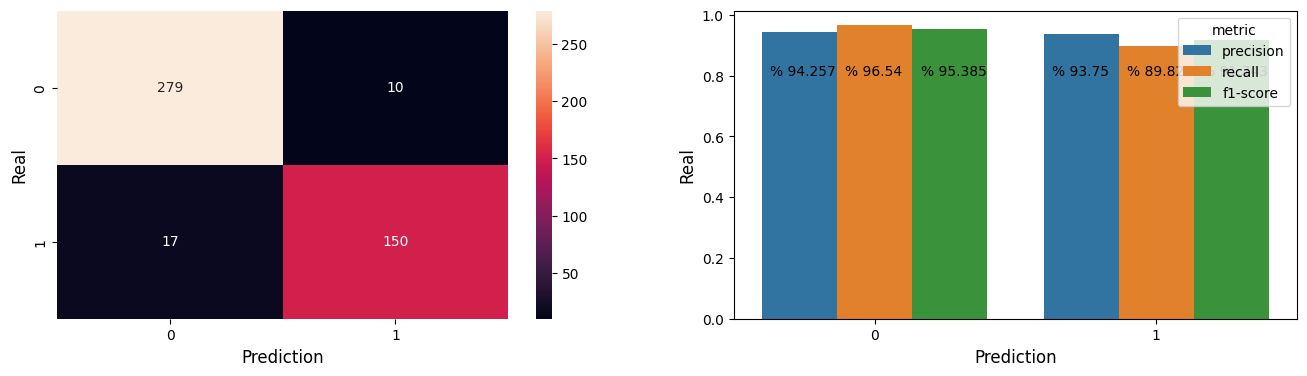

In [31]:
model = KNeighborsClassifier(n_neighbors=best_k, p=2,
                             weights='distance')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, output_dict=True)

evaluation_results = CalculateAndAppendMetrics(evaluation_results, y_test, y_pred, "K-Nearest Neighbors")

diagnosis = []
metrics = []
values = []
for index, item in cr.items():

    if index not in ["0", "1"]:
        break
    for metric, value in item.items():
        if metric == "support":
            continue
        diagnosis.append(index)
        metrics.append(metric)
        values.append(value)

cr_data = pd.DataFrame({
    'diagnosis': diagnosis,
    'metric': metrics,
    'value': values
})

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

plt.subplot(1, 2, 2)
bar_plot = sns.barplot(data=cr_data, x='diagnosis', y='value', hue='metric')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

for i in bar_plot.patches[:6]:
    bar_plot.annotate(f"% {round(i.get_height() * 100, 3)}", xy=(i.xy[0] + 0.03, 0.8))
plt.show()


# Decision Trees

In [32]:
# The dataset is split into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, -1:], test_size=0.8, random_state=1)

### Cross-validation

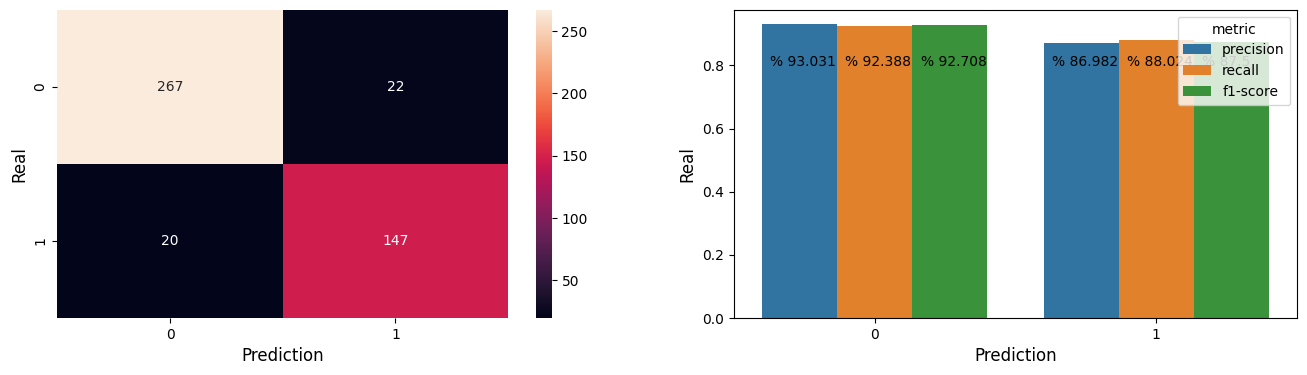

In [33]:
params = {
    "max_depth" : [3,5,10],
    "min_samples_split" : [2,10,20],
    "min_samples_leaf": [1,5,10],
    "ccp_alpha" : [0.0,0.01, 0.1]
}

# The data is normalized for both the training and test sets.

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), params, cv=5, scoring="precision")
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

model = DecisionTreeClassifier(**best_params, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, output_dict=True)

evaluation_results = CalculateAndAppendMetrics(evaluation_results, y_test, y_pred, "Decision Trees")

diagnosis = []
metrics = []
values = []
for index, item in cr.items():

    if index not in ["0", "1"]:
        break
    for metric, value in item.items():
        if metric == "support":
            continue
        diagnosis.append(index)
        metrics.append(metric)
        values.append(value)

cr_data = pd.DataFrame({
    'diagnosis': diagnosis,
    'metric': metrics,
    'value': values
})

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

plt.subplot(1, 2, 2)
bar_plot = sns.barplot(data=cr_data, x='diagnosis', y='value', hue='metric')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

for i in bar_plot.patches[:6]:
    bar_plot.annotate(f"% {round(i.get_height() * 100, 3)}", xy=(i.xy[0] + 0.03, 0.8))
plt.show()

# Neural Network

In [34]:
# The dataset is split into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, -1:], test_size=0.8, random_state=1)

### Cross-validation

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


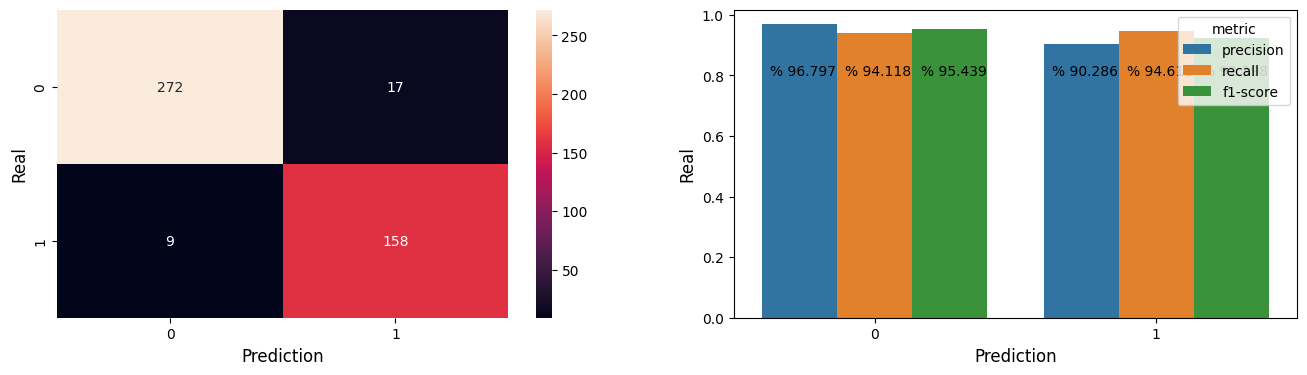

In [37]:
params = {
    "units":[10,20,30],
    "learning_rate":[0.001,0.002, 0.003, 0.004]
}

# The data is normalized for both the training and test sets.
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

def create_model(units,learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(30,)))
    model.add(tf.keras.layers.Dense(units= units, activation='relu'))
    model.add(tf.keras.layers.Dense(units= 1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="binary_crossentropy", metrics=["accuracy"])

    return model

keras_model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0, learning_rate=0.01, units=10)
grid_search = GridSearchCV(estimator=keras_model, param_grid = params, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

model = create_model(**best_params)
model.fit(X_train, y_train, epochs=100, verbose=0)
y_pred = model.predict(X_test)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, output_dict=True)

evaluation_results = CalculateAndAppendMetrics(evaluation_results, y_test, y_pred, "Red Neuronal")

diagnosis = []
metrics = []
values = []
for index, item in cr.items():

    if index not in ["0", "1"]:
        break
    for metric, value in item.items():
        if metric == "support":
            continue
        diagnosis.append(index)
        metrics.append(metric)
        values.append(value)

cr_data = pd.DataFrame({
    'diagnosis': diagnosis,
    'metric': metrics,
    'value': values
})

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

plt.subplot(1, 2, 2)
bar_plot = sns.barplot(data=cr_data, x='diagnosis', y='value', hue='metric')
plt.xlabel("Prediction", fontsize=12)
plt.ylabel("Real", fontsize=12)

for i in bar_plot.patches[:6]:
    bar_plot.annotate(f"% {round(i.get_height() * 100, 3)}", xy=(i.xy[0] + 0.03, 0.8))
plt.show()


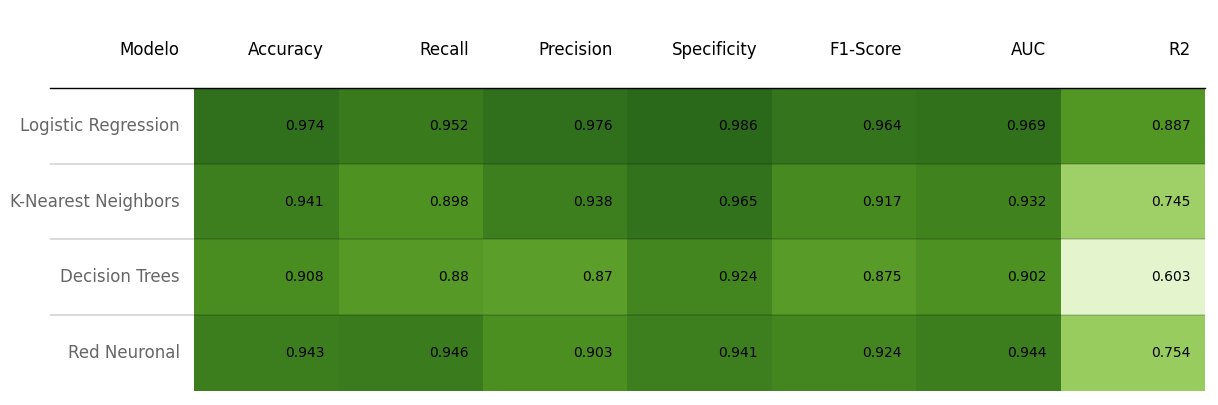

In [38]:
from plottable import ColumnDefinition
from matplotlib.cm import RdYlGn,YlGn, summer, Greens, viridis, cividis, plasma_r, PiYG

fig, ax = plt.subplots(figsize=(15, 5))
tab = Table(evaluation_results.round(3).T.rename_axis("Modelo"),
            column_definitions=[
                ColumnDefinition(name="Accuracy", cmap=PiYG),
                ColumnDefinition(name="Recall", cmap=PiYG),
                ColumnDefinition(name="Precision", cmap=PiYG),
                ColumnDefinition(name="Specificity", cmap=PiYG),
                ColumnDefinition(name="F1-Score", cmap=PiYG),
                ColumnDefinition(name="AUC", cmap=PiYG),
                ColumnDefinition(name="R2", cmap=PiYG),
                ]
            )
tab.col_label_row.set_fontsize(12)
tab.columns["Modelo"].set_fontsize(12)
tab.columns["Modelo"].set_fontcolor("#666666")
plt.show()